# Setup environment

In [1]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.4 MB/s eta 0:00:00


In [2]:
import random

import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [3]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [5]:
dataset = pd.read_csv("twitter-suicidal-data.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [7]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
def convert_emoji_to_text(text):
    return emoji.replace_emoji(text,replace= " ")

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    text = text.lower()

    text = re.sub(r'\d+', ' ', text)

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    text = re.sub(r'@\w+', '', text)

    text = re.sub(r'[^\w\s]', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    text = convert_emoji_to_text(text)

    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word, nltk_pos_tagger(tag)) for word, tag in pos_tags]

    tokens = [token for token in lemmatized_tokens if token not in stopwords]

    return tokens

In [9]:
test_str = "Hello! i am Mohammad, i am 22 years old and i'm happy to see      you : www.Mosad.com is my webSite which designed by @David"
editted = preprocess_data(test_str)
print(editted)

['hello', 'mohammad', 'year', 'old', 'happy', 'see', 'website', 'design']


<h2>Lowercase</h2>
<p>converting all words to lowercase format is common step in NLP which is usefull for simplicity and also reducing count of uniqe words.</p>
<ul>
    <li><b>Advantage: </b> ensures that words are treated uniformly, regardless of their original case. Also it simplifies the text by reducing the number of distinct tokens which it leads to compare and analyze become easier.</li>
    <li><b>disAdvantage: </b>Lowercasing can cause the loss of information related to proper nouns, acronyms, and other case-sensitive data. Furthermore Certain words might have different meanings based on their case. For instance, "May" (the month) and "may" (a modal verb) are distinct in their meanings.</li>
</ul>
<h2>Removing Numbers</h2>
<p>Removing numbers is generally useful for simplifying text data and focusing on its semantic content. However, the decision to remove numbers depends on our data type and the importance of numeric information within your text data.</p>
<ul>
    <li><b>Advantage: </b>Removing numbers can help clean the data by eliminating numeric noise, which might not be relevant for many text-based analyses.A smaller vocabulary size leads to simplified models that are easier to train and require less computational resources.</li>
    <li><b>disAdvantage: </b>Numbers often carry significant contextual information, such as dates, quantities, prices, and measurements. Removing them can lead to a loss of important information.also it can skew the data and misrepresent the actual content, leading to potential misinterpretations or biased results.</li>
</ul>
<h2>Hashtag</h2>
<p>Retaining hashtags in Twitter text analysis enables researchers, analysts, and data scientists to gain deeper insights into user-generated content, community engagement, topic trends, and sentiment dynamics on Twitter. By preserving hashtags, analysts can leverage the rich contextual information embedded within tweets, facilitating more comprehensive and accurate analyses of Twitter data.</p>

In [10]:
import random
indexes = [random.randint(0,9118) for _ in range(3)]
for i in indexes:
    print(dataset["tweet"][i])
    print(preprocess_data(dataset["tweet"][i]))
    print("--------------------------------------------------------------------------")

no i don t want to go on firstly i want to apologize for my english skill there and every thoughti m afraid it will be a shitpost but now now my head is a mess too everything get the worst it could it is the end of the day i was online i think the whole day checking my ex s account waiting for a miracle maybe recently she showed the signs she misses me very much added my music now deleted i saw her in school yesterday eye contact first time in 3 months it was an abusive and horrible relationship for me but after a month of nocontact i still can t move on all my online actions are connected with her i m going insane it s very obsessive and and i just remembered everything everything that happened in the last 5 months i think i have two large posts about it there but it doesn t really matter now i just feel it i should go no regrets already this state of mind messywhat are the problems ok so i m 17 year old transgender female on diy hrt in a homophobic and dangerous country environment i

Statistics by Label:
           min   max       mean
intention                      
0            0    38   8.972857
1            1  2142  73.647824

Overall Statistics:
min        0.000000
max     2142.000000
mean      37.327996
Name: tokenNumber, dtype: float64


<ipython-input-19-e0a4bf5cd3ac>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='tokenNumber', data=df_non_suicidal, ax=axes[0], palette='Set3')
<ipython-input-19-e0a4bf5cd3ac>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='tokenNumber', data=df_suicidal, ax=axes[1], palette='Set3')


<Figure size 1200x600 with 0 Axes>

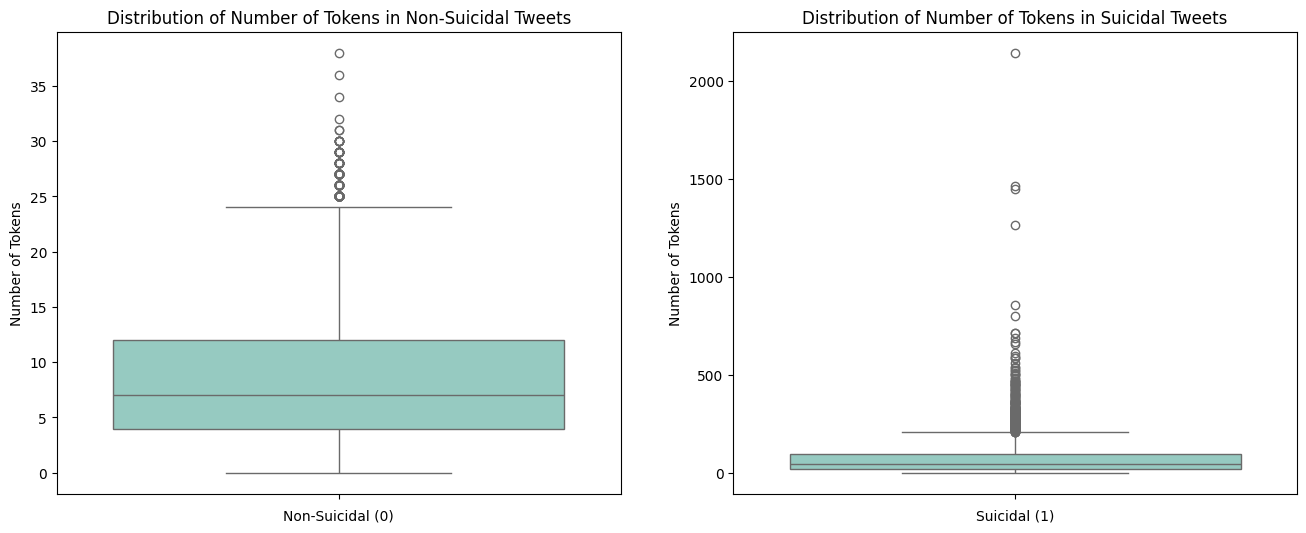

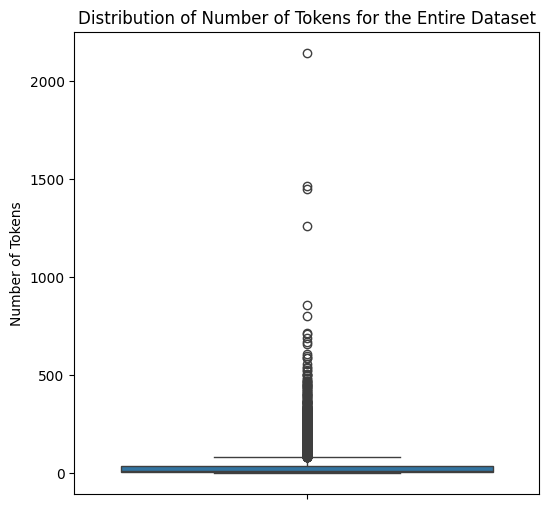

In [19]:
#add number of tokens for each tweet

dataset["tokenNumber"] = dataset["tweet"].apply(lambda x : len(preprocess_data(x)))

info = dataset.groupby('intention')['tokenNumber'].agg(['min', 'max', 'mean'])
overall_info = dataset['tokenNumber'].agg(['min', 'max', 'mean'])

print("Statistics by Label:")
print(info)
print("\nOverall Statistics:")
print(overall_info)

# Create the box plot
plt.figure(figsize=(12, 6))

df_non_suicidal = dataset[dataset['intention'] == 0]
df_suicidal = dataset[dataset['intention'] == 1]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for non-suicidal tweets
sns.boxplot(y='tokenNumber', data=df_non_suicidal, ax=axes[0], palette='Set3')
axes[0].set_title('Distribution of Number of Tokens in Non-Suicidal Tweets')
axes[0].set_xlabel('Non-Suicidal (0)')
axes[0].set_ylabel('Number of Tokens')

# Boxplot for suicidal tweets
sns.boxplot(y='tokenNumber', data=df_suicidal, ax=axes[1], palette='Set3')
axes[1].set_title('Distribution of Number of Tokens in Suicidal Tweets')
axes[1].set_xlabel('Suicidal (1)')
axes[1].set_ylabel('Number of Tokens')

plt.show()

# Plot for the entire dataset
plt.figure(figsize=(6, 6))
sns.boxplot(y=dataset['tokenNumber'])
plt.title('Distribution of Number of Tokens for the Entire Dataset')
plt.ylabel('Number of Tokens')
plt.show()

# Word2Vec - Word Embedding

In [20]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [21]:
W2V_PATH = None # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.


In [22]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

<h2>Out Of Vocab words</h2>
<p>for handling the tokens which are not exist in our w2v model, there are some approach to apply:</p>
<ul>
  <li>Ignore OOV Words</li>
  <li>Zero Padding</li>
  <li>Special Token</li>
</ul>

# Dataset

In [42]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe.loc[:,self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        vectors = np.zeros((self.max_sequence_len,self.vector_size))
        for i, token in enumerate(tokens):
          if token in self.w2v_model:
              vectors[i] = self.w2v_model[token]

        return torch.tensor(vectors.T, dtype=torch.long)

    def _pad(self, tokens: list):
        padding_len = self.max_sequence_len - len(tokens)
        if padding_len > 0:
            tokens.extend(['<PAD>'] * padding_len)
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [24]:
train_data , test_data = train_test_split(dataset,test_size=0.2,random_state=42)

In [25]:
print(len(train_data))

7295


## Create Datasets

In [43]:
# TODO: create twitter dataset
train_dataset = Twitter(
    train_data , w2v_model , 64
)
valid_dataset = Twitter(
    test_data , w2v_model , 64
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 23


<ipython-input-42-21987f31553b>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Deleted 0-Len Samples: 8
Train dataset length: 7272
Valid dataset length: 1816


<ipython-input-42-21987f31553b>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


# Model and Train

## Utils

In [44]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = "auto"):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs,labels)

        correct = (outputs.argmax(dim=1)== labels).sum().item()
        test_acc += correct / labels.size(0)
        test_loss += loss.item()

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    return test_loss, test_acc


In [45]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str = "auto",
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
    valid_loader = DataLoader(valid_set,batch_size=batch_size)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []


    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for idx, (inputs, labels) in enumerate(itr, start=1):

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()  #step2
            optimizer.step() #step3

            epoch_loss += loss.item()
            correct = (outputs.argmax(dim=1) == labels).sum().item()
            epoch_acc += correct / labels.size(0)

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc, 5),
              )

        epoch_loss /= len(train_loader)
        epoch_acc /= len(train_loader)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [46]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [47]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    # Iterate through the dataset
    for batch in itr:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Store labels and predictions
        labels.extend(labels.cpu().numpy())
        predicted.extend(preds.cpu().numpy())

    # Convert lists to arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [55]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self,vocab_size,embed_size,classesNumber):
        super(CNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size , embed_size)
        self.conv1 = nn.Conv1d(in_channels=embed_size , out_channels=64 ,kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=64 , out_channels=128 ,kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size= 2)
        self.fc1 = nn.Linear(128*3 , 128)
        self.fc2 = nn.Linear(128 , classesNumber)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1,2)
        x = F.sigmoid(self.conv1(x))
        x = F.sigmoid(self.conv2(x))
        x = self.pool(x)
        #Flatten
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Training

In [58]:
model = CNN(64,300,2)

In [60]:
import torch.optim as optim
cnn_model_train_history = train_model(model = model,batch_size= BATCH_SIZE,
epochs= EPOCHS , train_set = train_dataset , valid_set = valid_dataset , loss_function = nn.CrossEntropyLoss(),optimizer=optim.Adam(model.parameters()))

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [64, 64, 300, 300]

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

In [ ]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [ ]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])